# 유전알고리즘 최종 코드

## 인공지능연구실 ( 이상근 교수님 )
### 학번 : 2018108005
### 석사과정 2기 손수현

---------

In [4]:
import random
import numpy as np
from random import shuffle
import operator
from scipy import spatial
from multiprocessing import Pool
from sklearn.metrics.pairwise import cosine_similarity
import time
from multiprocessing import Pool

## 하이퍼 파라미터

In [5]:
# 모집단 수
POPULATION_SIZE = 1000

# 최대 세대
STOP_GENERATION = 500

# 교차 연산 후 생성할 자손의 개수
HOW_MANY_CROSSOVER = POPULATION_SIZE * 0.5

# 지수귀문도 노드 개수
NODE_NUM = 70

ELITE_GENE = 10
NOT_ELITE_GENE = POPULATION_SIZE - ELITE_GENE

# Effective fitness를 계산하기 위해 유전자와 출현 빈도를 저장할 글로벌 변수
GENE_AGE = {}


## Representation
- 차원 5

In [6]:
hex_1 = [0, 1, 2, 4, 5, 6]
hex_2 = [5, 6, 7, 9, 10, 11]
hex_3 = [3, 4, 5, 11, 12, 13]
hex_4 = [8, 9, 10, 20, 21, 22]
hex_5 = [10, 11, 12, 18, 19, 20]
hex_6 = [12, 13, 14, 16, 17, 18]
hex_7 = [21, 22, 23, 25, 26, 27]
hex_8 = [19, 20, 21, 27, 28, 29]
hex_9 = [17, 18, 19, 29, 30, 31]
hex_10 = [15, 16, 17, 31, 32, 33]
hex_11 = [24, 25, 26, 43, 44, 45]
hex_12 = [26, 27, 28, 41, 42, 43]
hex_13 = [28, 29, 30, 39, 40, 41]
hex_14 = [30, 31, 32, 37, 38, 39]
hex_15 = [32, 33, 34, 35, 36, 37]
hex_16 = [42, 43, 44, 46, 47, 48]
hex_17 = [40, 41, 42, 48, 49, 50]
hex_18 = [38, 39, 40, 50, 51, 52]
hex_19 = [36, 37, 38, 52, 53, 54]
hex_20 = [47, 48, 49, 59, 60, 61]
hex_21 = [49, 50, 51, 57, 58, 59]
hex_22 = [51, 52, 53, 55, 56, 57]
hex_23 = [58, 59, 60, 62, 63, 64]
hex_24 = [56, 57, 58, 64, 65, 66]
hex_25 = [63, 64, 65, 67, 68, 69]

In [7]:
hex_index = []
hex_index.append(hex_1)
hex_index.append(hex_2)
hex_index.append(hex_3)
hex_index.append(hex_4)
hex_index.append(hex_5)
hex_index.append(hex_6)
hex_index.append(hex_7)
hex_index.append(hex_8)
hex_index.append(hex_9)
hex_index.append(hex_10)
hex_index.append(hex_11)
hex_index.append(hex_12)
hex_index.append(hex_13)
hex_index.append(hex_14)
hex_index.append(hex_15)
hex_index.append(hex_16)
hex_index.append(hex_17)
hex_index.append(hex_18)
hex_index.append(hex_19)
hex_index.append(hex_20)
hex_index.append(hex_21)
hex_index.append(hex_22)
hex_index.append(hex_23)
hex_index.append(hex_24)
hex_index.append(hex_25)

# Initialization
- 랜덤하게 숫자를 노드 개수만큼 뽑아서 리스트에 저장함.
- 모집단 개수만큼 반복해 2차원 리스트 형태로 리턴함.

In [10]:
def initial_pop(population_size):
    population = []
    for i in range(population_size):
        # 숫자를 랜덤으로 뽑아 리스트를 만듬. 
        # 1부터 70까지 랜덤으로 뽑은 리스트 값이 gene에 저장됨.
        gene = random.sample(range(1,NODE_NUM+1), NODE_NUM)
        # 모집단에 추가.
        population.append(gene)
    return np.array(population)

# Crossover
- 2차 교차를 구현함.
- 랜덤하게 자를 2개의 위치를 선정한 뒤 유전자 값을 교체해줌

In [11]:
def crossover(gene_, gene2_):
    gene1 = gene_.copy()
    gene2 = gene2_.copy()
    # 랜덤으로 자를 위치를 정함.
    two_point = sorted(random.sample(range(0,NODE_NUM), 2))
    temp = gene1[0:two_point[0]]
    gene1[0:two_point[0]] = gene2[0:two_point[0]]
    gene2[0:two_point[0]] = temp
    
    temp = gene1[two_point[1]:]
    gene1[two_point[1]:] = gene2[two_point[1]:]
    gene2[two_point[1]:] = temp
    return gene1, gene2

# Repairment
- 범위에서 벗어나는 숫자를 0으로, 혹은 중복해서 나오는 숫자를 0으로 바꿈.
- 한 번만 나온 숫자들을 따로 변수에 저장.
- 1부터 70까지 숫자 중, 한 번만 나온 숫자들을 제외하고 0의 값에 채워야 할 숫자를 정함.
- 랜덤으로 숫자를 채워줌.

In [12]:
def repairment(gene_):
    gene = gene_.copy()
    gene_element = set(gene)
    unique_val = []
    for idx, gene_element in enumerate(gene):
        # 범위에서 벗어나는 숫자들을 0으로 바꿔줌.
        if gene_element < 1 or gene_element > NODE_NUM : 
            gene[idx] = 0
            continue
        if gene_element == 0: continue
        # 처음 등장하는 숫자를 변수에 저장함.
        if gene_element not in unique_val:
            unique_val.append(gene_element)
            continue
            
        # 중복해서 나온 경우, 0으로 바꾸고 unique_val 변수에서 해당 숫자를 삭제.
        tmp_idx = np.where(gene == gene_element)[0]
        gene[tmp_idx] = 0
        unique_val.remove(gene_element)
        
    # 1부터 70 사이에 unique_val에 없는 숫자들로만 가져옴. ( 0 위치에 채워 넣어야 할 숫자 )
    fill_element = [i for i in range(1, NODE_NUM+1, 1) if i not in unique_val]
    # 리스트를 섞어줌
    shuffle(fill_element)
    # 유전자에서 0의 위치에 랜덤하게 섞은 숫자들을 채워 넣음.
    for idx, gene_idx in enumerate(np.where(gene==0)[0]):
        gene[gene_idx] = fill_element[idx]
    return gene

# Mutation
- 랜덤으로 0에서 100 사이에 소수를 뽑음.
- 1일 때랑 70일때는 제외.
- 33보다 작으면 1 증가, 67보다 크면 1 감소

In [13]:
def mutation(gene_):
    gene = gene_.copy()
    #print("Mutation : " + str(sum(gene)))
    for idx in range(len(gene)):
        if gene[idx] == 1 or gene[idx] == NODE_NUM : continue
        random_num = random.randint(0, 100)
        if random_num < 33:
            gene[idx] += 1
            continue
        if random_num >67:
            gene[idx] -= 1
            continue
    return repairment(gene)

# Evaluation
- Effective fitness와 fitness를 구현
- 글로벌 변수 GENE_AGE에 저장된 유전자로부터 빈도수를 가져와 effective fitness를 계산함.
- GENE_AGE에 없으면 age는 0으로 함.


In [14]:
def effective_fitness(gene_, hex_index):
    gene_age = 0
    gene = gene_.copy()
    gene = np.array(gene)
    # GENE_AGE 딕셔너리 변수에 유전자가 있으면, 유전자의 age를 가져옴.
    if str(gene) in GENE_AGE.keys():
        gene_age = GENE_AGE[str(gene)]

    # 0.004는 차원 5일 때의 육각형 25개에 10을 곱한 뒤 역수를 취한 값. ( 논문 참고 )
    effective_fitness = fitness_eval(gene, hex_index) - 0.004 * gene_age
    
    # 유전자 하나에 대한 실수값을 리턴
    return effective_fitness


In [15]:
def effective_fitness_dict(population, hex_index):
    # 추후 대치(replacement)에서 사용하기 위해 유전자별로 effective fitness를 계산해 딕셔너리 자료구조를 리턴함.
    # key는 유전자. value는 effective fitness가 들어감.
    ef_dict = {}
    for idx, gene in enumerate(population):
        gene_age = 0
        if str(gene) in GENE_AGE.keys():
            gene_age = GENE_AGE[str(gene)]
        ef_dict[idx] = fitness_eval(gene, hex_index) - 0.004 * gene_age
    return ef_dict


In [16]:
def fitness_eval(gene, hex_index):
    # 일반적으로 유전자 자체에 대한 fitness를 평가하기 위한 함수.
    # 각각의 육각형에 대한 분산에 마이너스를 곱한 값을 리턴.
    hex_sum = []
    for i in hex_index:
        hex_sum.append(sum(np.array(gene)[i]))
    return -np.var(hex_sum)

# Replacement

- 입력으로 들어오는 popoulation은 crossover로 생성된 자손 개수만큼 더해진 population임.
- 예) population : 500, children : 250 => replacement에 들어오는 population 개수는 750개
- 최종 보고서에는 750개 중, effective fitness 500개로 구성된 새로운 population이 다음 세대가 됨.
- 이외에도, 랜덤으로 500개를 뽑는 방법, 엘리티즘을 사용한 방법 등을 사용해봄.(최종보고서 미기입)

In [17]:
def replacement(population, hex_index):
    # 버려야 할 유전자 개수를 변수에 저장함. 
    drop_gene_num = len(population) - POPULATION_SIZE
    
    # 유전자별로 effective fitness 정보가 있는 딕셔너리 자료구조
    ef_gene_dict = effective_fitness_dict(population, hex_index)
    
    # effective fitness가 낮은 순서대로 정렬.
    sorted_ef_gene_dict = sorted(ef_gene_dict.items(), key=operator.itemgetter(1))
    # 유전자 index를 가져옴.
    genes_ = [i[0] for i in sorted_ef_gene_dict]
    
    # effective fitness가 낮은 유전자의 인덱스를 저장.
    drop_gene_idx = genes_[:drop_gene_num]
    
    next_population = [gene for idx, gene in enumerate(population) if idx not in drop_gene_idx]
    return next_population

In [18]:
def replacement_random(population, hex_index):
    
    drop_gene_num = POPULATION_SIZE - len(population)
    ef_gene_dict = effective_fitness_dict(population, hex_index)
    sorted_ef_gene_dict = sorted(ef_gene_dict.items(), key=operator.itemgetter(1))
    genes_ = [i[0] for i in sorted_ef_gene_dict]
    drop_gene_idx = genes_[:drop_gene_num]
    
    next_population = [gene for idx, gene in enumerate(population) if idx not in drop_gene_idx]
    
    select_idx = random.sample(range(0,len(population)), NOT_ELITE_GENE)

    return next_population

In [19]:
def Elitism_replacement(population, hex_index, eliete_num):

    effective_fitness_gene = effective_fitness()
    best_genes = sorted(effective_fitness_gene.items(), key=operator.itemgetter(1), reverse=True)
    genes_ = [i[0] for i in best_genes]
    elite = genes_[:ELITE_GENE]
    
    not_elite = [i for i in genes_ if i not in elite]
    select_idx = random.sample(range(0,len(not_elite)), NOT_ELITE_GENE)
    not_elite = [gene for i, gene in enumerate(not_elite) if i in select_idx]
    next_population = np.append(elite, not_elite, axis=0)

    return next_population

# Consecutive_exchange

- 논문을 구현. 
- 값의 차이가 1 혹은 N일 때 위치를 바꿨을 때 fitness의 증가가 있으면 위치를 바꿔줌.

In [20]:
def change(idx1, idx2, gene):
    gene_ = gene.copy()
    tmp = gene_[idx1]
    gene_[idx1] = gene_[idx2]
    gene_[idx2] = tmp
    return gene_

In [21]:
def gain(idx1, idx2, gene):
    before_eval = fitness_eval(gene, hex_index)
    gene_ = gene.copy()
    k = gene_[idx1]
    gene_[idx1] = gene_[idx2]
    gene_[idx2] = k
    after_eval = fitness_eval(gene_, hex_index)
    # fitness가 같으면 0을 리턴.
    if before_eval == after_eval:
        return 0
    # fitness가 증가하면 1을 리턴, 감소하면 -1을 리턴.
    result = 1 if before_eval - after_eval < 0 else -1
    return result

In [22]:
def M_consecutive_exchange(gene):
    changed=True
    while(changed):
        changed=False
        for i in range(len(gene)):
            num = i+1
            if num == NODE_NUM: continue
            l0 = np.where(np.array(gene)==num)[0][0]
            l1 = np.where(np.array(gene)==num+1)[0][0]
            # fitness가 증가하면 값을 바꿔줌.
            if gain(l0, l1, gene) == 1:
                gene = change(l0, l1, gene)
                changed=True

    return gene

In [23]:
def M_consecutive_exchange_2(gene):
    changed=True
    while(changed):
        changed=False
        for i in range(len(gene)):
            num = i+1
            if num == NODE_NUM-1: continue
            l0 = np.where(np.array(gene)==num)[0][0]
            l1 = np.where(np.array(gene)==num+2)[0][0]
            if gain(l0, l1, gene) == 1:
                gene = change(l0, l1, gene)
                changed=True

    return gene

In [24]:
def M_consecutive_exchange_3(gene):
    changed=True
    while(changed):
        changed=False
        for i in range(len(gene)):
            num = i+1
            if num == NODE_NUM-2: continue
            l0 = np.where(np.array(gene)==num)[0][0]
            l1 = np.where(np.array(gene)==num+3)[0][0]
            if gain(l0, l1, gene) == 1:
                gene = change(l0, l1, gene)
                changed=True

    return gene

In [48]:
def M_consecutive_exchange_tabu(gene_):
    T = []
    gene = gene_.copy()
    changed=True
    while(changed):
        changed=False
        for i in range(len(gene)):
            num = i+1
            if num == NODE_NUM: continue
            l0 = np.where(np.array(gene)==num)[0][0]
            l1 = np.where(np.array(gene)==num+1)[0][0]
            if gain(l0, l1, gene) == 1:
                gene = change(l0, l1, gene)
                T = [gene]
                changed=True

            elif gain(l0, l1, gene) == 0 and sum([sum(i==gene) == NODE_NUM for i in T]) <= 1:
                T.append(gene)
                gene = change(l0, l1, gene)
                changed=True
    return gene

# NearbySearch

In [22]:
def NearbySearch(gene):
    hex_mean_total = [sum(np.array(gene)[i]) for i in hex_index]
    hex_mean_total = np.mean(hex_mean_total)
    origin_fitness = fitness_eval(gene, hex_index)
    #assert(False)
    gene_error_list = []
    for gene_index in range(len(gene)):
        hex_gene_index = [idx for idx, i in enumerate(hex_index) if gene_index in i]
        gene_error = [sum(np.array(gene)[i]) - hex_mean_total  for i in np.array(hex_index)[hex_gene_index]]
        gene_error_list.append(gene_error[0])
        #assert(False)
    
    low_point = pd.Series(gene_error_list).quantile([0.2, 0.8]).values[0]
    high_point = pd.Series(gene_error_list).quantile([0.2, 0.8]).values[1]
    small_error_idx = ([idx for idx, i in enumerate(gene_error_list) if i <= low_point])
    large_error_idx = ([idx for idx, i in enumerate(gene_error_list) if i >= high_point])
    pd.Series(gene_error_list).hist()
    modified_gene = [i+1 if idx in small_error_idx and i < 69  else i for idx, i in enumerate(gene) ]
    modified_gene = [i-1 if idx in large_error_idx and i >2  else i for idx, i in enumerate(gene) ]
    modified_gene = repairment(np.array(modified_gene))
    
    gene2 = M_consecutive_exchange(modified_gene)
    gene2_fitness = fitness_eval(gene2, hex_index)
    #print("origin fitness : " + str(origin_fitness))
    #print("gene2 fitness : " + str(gene2_fitness))
    if origin_fitness <= gene2_fitness:
        #print("Gene2 is better")
        return gene2
    else:
        return gene

In [23]:
def NearbySearch_origin(gene):
    hex_mean_total = [sum(np.array(gene)[i]) for i in hex_index]
    hex_mean_total = np.mean(hex_mean_total)
    origin_fitness = fitness_eval(gene, hex_index)
    gene_error_list = []
    for gene_index in range(len(gene)):
        hex_gene_index = [idx for idx, i in enumerate(hex_index) if gene_index in i]
        gene_error = [sum(np.array(gene)[i]) - hex_mean_total  for i in np.array(hex_index)[hex_gene_index]]
        gene_error_list.append(gene_error[0])

    lowest_error_val = min(gene_error_list)
    highest_error_val = max(gene_error_list)
    low_point = np.where(np.array(gene_error_list) == lowest_error_val)[0]
    high_point = np.where(np.array(gene_error_list) == highest_error_val)[0]
    modified_gene = gene.copy()
    modified_gene[low_point] += 1
    modified_gene[high_point] -=1
    modified_gene = repairment(np.array(modified_gene))
    gene2 = M_consecutive_exchange(modified_gene)
    gene2_fitness = fitness_eval(gene2, hex_index)
    if origin_fitness <= gene2_fitness:
        return gene2
    else:
        return gene

# Age
- 모든 연산이 끝나고, 글로별 변수 GENE_AGE에 모집단을 추가함.
- GENE_AGE에 유전자가 있으면 value값에 1을 더하고, key에 등록이 안된 경우 0으로 초기화함

In [24]:
def aging_gene(population):
    if GENE_AGE == {}:
        for gene in population:
            GENE_AGE[str(gene)] = 0
        return
    for gene in population:
        if str(gene) not in GENE_AGE.keys():
            GENE_AGE[str(gene)] = 0
        GENE_AGE[str(gene)] += 1
    return

# 연산자 합침
- 부모 인덱스 2개만 받으면 모집단에서 부모 유전자를 가져와서 교차, 변이, 지역최적화, 토너먼트 연산을 수행
- 자손 2개 중 적합도가 높은 자손 유전자를 리턴함

In [25]:
def crossover_mutation_localopt_tournament(p1_, p2_):
    population = POPULATION.copy()
    p1 = population[p1_].copy()
    p2 = population[p2_].copy()
        
    c1, c2 = crossover(p1, p2)
    c1 = mutation(c1)
    c1 = M_consecutive_exchange(c1)
    c2 = M_consecutive_exchange(c2)
    c1_fitness = fitness_eval(c1, hex_index)
    c2_fitness = fitness_eval(c2, hex_index)
    
    if c1_fitness >= c2_fitness:
        #POPULATION.append(c1)
        return c1
    else: 
        #POPULATION.append(c2)
        return c2
    

# 코사인 선택
- 유전자를 입력으로 받아, 모집단 중 코사인 유사도가 가장 떨어진 유전자를 선택해 교차, 변이, 지역최적화, 토너먼트를 연산을 수행
- 2개의 자손 중 적합도가 높은 유전자를 리턴

In [27]:
def cosine_selection_crossover_mutation_localopt_tournament(gene_):
    cosine_similarity_dict = {}
    for idx, gene in enumerate(POPULATION):
        similarity = cosine_similarity([gene_], [gene])
        cosine_similarity_dict[idx] = similarity[0][0]
    smallest_similarity = sorted(cosine_similarity_dict.items(), key=operator.itemgetter(1))[0]
    smallest_similarity_idx = smallest_similarity[0]
    smallest_similarity_gene = POPULATION[smallest_similarity_idx]
    
    c1, c2 = crossover(gene_, smallest_similarity_gene)
    c1 = mutation(c1)
    c2 = mutation(c2)
    c1 = M_consecutive_exchange(c1)
    c2 = M_consecutive_exchange(c2)
    c1_fitness = fitness_eval(c1, hex_index)
    c2_fitness = fitness_eval(c2, hex_index)
    
    if c1_fitness >= c2_fitness:
        return c1
    else:
        return c2
    

# 코사인 선택 후 교체 연산
- 코사인 선택으로 생성된 자손은 fitness값이 낮아 기존 교체 연산에 넣으면 다음 세대에 살아남지 못할 확률이 큼.
- 코사인 선택으로 생성된 자손은 다음 세대에 넘어갈 때 생존시키고, 추가된 부분은 기존 모집단에서 랜덤으로 교체함

In [29]:
def replacement_random(population, saving_children):
    child_num = len(saving_children)
    
    random_idx = (random.sample(range(0, len(population)), len(population) - child_num))
    population = population[random_idx]
    population = np.append(population, saving_children, axis=0)
    print("Replace random population len : " + str(len(population)))
    return population

# 적합도 높은 유전자 선택
- 일반적인 fitness함수로 현재 모집단 중 적합도가 가장 높은 K개의 유전자를 리턴받음

In [30]:
def top_k_gene(k_num, population, hex_index):
    fitness_dict = {}
    for idx,gene in enumerate(population):
        gene_fitness = fitness_eval(gene, hex_index)
        fitness_dict[idx] = gene_fitness
    sorted_fitness_dict = sorted(fitness_dict.items(), key=operator.itemgetter(1), reverse=True)
    top_k_genes = [i[0] for i in sorted_fitness_dict][:k_num]
    return population[top_k_genes]

-----------

# 유전알고리즘 종합

In [26]:
selection_fitness = []
fitness_mean = []
fitness_generation = []
POPULATION = []
shaking_fitness = []

def find_solution(seed):
    global POPULATION
    global GENE_AGE
    global selection_fitness
    global fitness_mean
    global fitness_generation
    
    
    population_size = POPULATION_SIZE
    last_generation = STOP_GENERATION

    GENE_AGE.clear()
    population = initial_pop(POPULATION_SIZE)
    pool = Pool(processes = 25)
    population = np.array(pool.map(M_consecutive_exchange, population))
    pool.close()
    pool.join()
    aging_gene(population)
    print("Initialize is end")
    
    
    for generation in range(last_generation):
        print("=="*30)
        print("Generation : " + str(generation))
        start = time.time()
        # Selection index
        parents_selection_idx = []
        for i in range(int(HOW_MANY_CROSSOVER)):
            parents_selection_idx.append(sorted(random.sample(range(0, POPULATION_SIZE), 2)))
        
        POPULATION = population.copy()
        start_cmlt = time.time()
        pool = Pool(processes = 25)
        children = np.array(pool.starmap(crossover_mutation_localopt_tournament, parents_selection_idx))
        pool.close()
        pool.join()
        end_cmlt = time.time()
        print("CMLT is done : " + str(end_cmlt - start_cmlt))
        population = np.append(population, children, axis=0)
        start_replace = time.time()
        
        population = replacement(population, hex_index)
        end_replace = time.time()
        print("Replacement is done : " + str(end_replace - start_replace))
        POPULATION = population.copy()
        for gene in population:
            fitness_gene = fitness_eval(gene, hex_index)
            if fitness_gene == 0:
                print("Find solution")
                return population
        
        # nearby search
        start_nearby = time.time()
        pool = Pool(processes = 50)
        population = np.array(pool.map(NearbySearch_origin, population))
        pool.close()
        pool.join()
        end_nearby = time.time()
        print("Nearbysearch is done : " + str(end_nearby - start_nearby))
        fitness_ = []
        max_fitness = -100
        max_fitness_gene = []
        for gene in population:
            fitness_gene = fitness_eval(gene, hex_index)
            if fitness_gene > max_fitness :
                max_fitness = fitness_gene
                max_fitness_gene = gene
            if fitness_gene == 0:
                print("Find solution")
                return population
            fitness_.append(fitness_gene)
        print("Max fitness : " + str(max(fitness_)))
        print("Mean fitness : " + str(np.mean(fitness_)))
        print("Variance fitness : " + str(np.var(fitness_)))
        print("Max fitness gene : " + str(max_fitness_gene))
        print("Sum of Max fitness gene : " + str(sum(max_fitness_gene)))
        print([sum(np.array(max_fitness_gene)[i]) for i in hex_index])
        fitness_mean.append(np.mean(fitness_))
            
        if generation != 0 and generation % 100 == 0:
            print("fitness_mean's variation : " + str(np.var(fitness_mean)))
            if np.var(fitness_mean) < 0.1:
                print("\n Shaking \n")
                start_shaking = time.time()
                top_k_genes_ = top_k_gene(150, population, hex_index)
                POPULATION = population.copy()
               
                pool = Pool(processes = 25)
                cosine_selection_children = np.array(pool.map(cosine_selection_crossover_mutation_localopt_tournament, top_k_genes_))
                pool.close()
                pool.join()
                
                population = replacement_random(population, cosine_selection_children)
                POPULATION = population.copy()
                end_shaking = time.time()
                print("Shaking is done : " + str(end_shaking - start_shaking))
                for gene in population:
                    fitness_gene = fitness_eval(gene, hex_index)
                    if fitness_gene == 0:
                        print("Find solution")
                        return population
                    fitness_.append(fitness_gene)
                shaking_fitness.append(fitness_gene)
            else:
                fitness_mean = []
        fitness_generation.append(fitness_)
                
        aging_gene(population)
        end = time.time()
        print("Generation End Time : " + str(end-start))
    return population

In [ ]:
%%time
# 해 찾기
solution = find_solution(1)

# Plot

In [38]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 세대별 평균 적합도를 나타낸 그래프

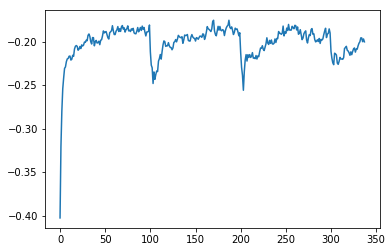

In [39]:
pd.Series([np.mean(sorted(i, reverse=True)) for i in fitness_generation]).plot()

### 세대별 적합도가 높은 100개의 유전자의 평균 적합도를 나타낸 그래프

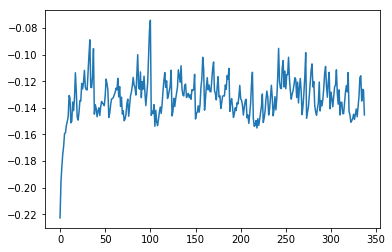

In [40]:
pd.Series([np.mean(sorted(i, reverse=True)[0:100]) for i in fitness_generation]).plot()

### 세대별 분산을 나타내는 그래프

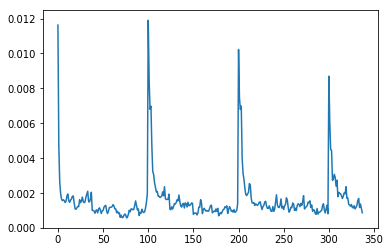

In [41]:
pd.Series([np.var(sorted(i, reverse=True)) for i in fitness_generation]).plot()

### 세대별 적합도 최댓값을 나타내는 그래프

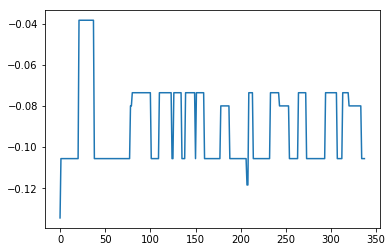

In [43]:
pd.Series([max(sorted(i, reverse=True)) for i in fitness_generation]).plot()

# Solution

In [34]:
[i for i in solution if fitness_eval(i, hex_index) == 0]

[array([ 9,  7, 70, 29, 25, 38, 69, 32,  6, 16, 13, 50, 37, 39, 11, 34, 18,
        52, 61,  1, 56, 63, 64,  2, 53, 58, 23,  8, 41, 49,  4, 51, 43, 20,
        55,  3, 67, 30, 22, 68, 21, 35, 46, 65,  5, 14, 66, 10, 26, 33, 57,
        31, 19, 36, 44, 59, 45, 28, 42, 27, 60, 62, 24, 17, 48, 40, 15, 12,
        47, 54])]

In [36]:
tmp = np.array([ 9,  7, 70, 29, 25, 38, 69, 32,  6, 16, 13, 50, 37, 39, 11, 34, 18,
        52, 61,  1, 56, 63, 64,  2, 53, 58, 23,  8, 41, 49,  4, 51, 43, 20,
        55,  3, 67, 30, 22, 68, 21, 35, 46, 65,  5, 14, 66, 10, 26, 33, 57,
        31, 19, 36, 44, 59, 45, 28, 42, 27, 60, 62, 24, 17, 48, 40, 15, 12,
        47, 54])

In [37]:
for i in hex_index:
    print(sum(tmp[i]))

218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
218
